# Random Shooting

For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding Random Shooting:

    Model Predictive Control paper: https://arxiv.org/pdf/1909.11652.pdf

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_random_shooting_example

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import RandomShooting
from relax.rl.models import DeltaEnvModel

from relax.zoo.models import ContObsContAcsToObsMLP, ContObsContAcsToRewsMLP

from relax.schedules import PiecewiseSchedule, LinearSchedule, CombinedSchedule

from relax.data.sampling import Sampler
from relax.data.replay_buffer import ReplayBuffer

from relax.gym.utils import visualize_actor

/home/nikita/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining RandomShooting actor

The simplest gradient-free optimizer simply generates N independent random action sequences, evaluates them using learned dynamics model and executes the first action from the best action sequence.

# Defining Environment Dynamics Models

DeltaEnvModel works only with continuous environments and it uses an ensemble of neural networks to model environment dynamics in the form: 

$ \hat{\Delta}_{t+1}  = f_{\theta}(s_{t}, a_{t})$


$ \hat{s}_{t+1} = \hat{\Delta}_{t+1} + s_{t} $

Which means that neural net models the change in state given the current state and action. Model itself as an input takes a batch of observations with a shape (BATCH_SIZE, \*obs.shape) and a batch of corresponding actions with a shape (BATCH_SIZE, ACS_DIM) and outputting a batch of $ \hat{\Delta}_{t+1} $ with a shape (BATCH_SIZE, \*obs.shape) (same shape as observations batch).

In case of absence of the privileged information - explicit reward function, it also may be modeled by an ensemble of neural networks in the following form: 


$ \hat{r}_{t} = f_{\phi}(s_{t}, a_{t}) $

Reward model itself as an input takes a batch of observations with a shape (BATCH_SIZE, \*obs.shape) and a batch of corresponding actions with a shape (BATCH_SIZE, ACS_DIM) and outputting a batch of rewards with a shape (BATCH_SIZE, 1).

Therefore any custom user defined networks meeting these requirements should work well with DeltaEnvModel environment model.

So let's examine the default implementation of observations and rewards models offered by ReLAx:

In [2]:
# Observations model:
print(getsource(ContObsContAcsToObsMLP))

class ContObsContAcsToObsMLP(nn.Module):
    
    def __init__(self, input_obs_dim, output_obs_dim,
                 acs_dim, nlayers,
                 nunits, activation=nn.Tanh(),
                 out_activation=nn.Identity()):
        
        super(ContObsContAcsToObsMLP, self).__init__()
        
        layers = []
        in_size = input_obs_dim + acs_dim
        for _ in range(nlayers):
            layers.append(nn.Linear(in_size, nunits))
            layers.append(activation)
            in_size = nunits
        
        self.layers = nn.Sequential(*layers)
        
        self.out_layer = nn.Sequential(
            nn.Linear(nunits, output_obs_dim),
            out_activation
        )

    def forward(self, obs, acs):
        
        out = self.layers(
            torch.cat(
                [torch.flatten(obs, start_dim=1), acs], 
                dim=-1
            )
        )
        out = self.out_layer(out)

        return out



In [3]:
# Rewards model:
print(getsource(ContObsContAcsToRewsMLP))

class ContObsContAcsToRewsMLP(nn.Module):
    
    def __init__(self, input_obs_dim,
                 acs_dim, nlayers,
                 nunits, activation=nn.Tanh(),
                 out_activation=nn.Identity()):
        
        super(ContObsContAcsToRewsMLP, self).__init__()
        
        layers = []
        in_size = input_obs_dim + acs_dim
        for _ in range(nlayers):
            layers.append(nn.Linear(in_size, nunits))
            layers.append(activation)
            in_size = nunits
        
        self.layers = nn.Sequential(*layers)
        
        self.out_layer = nn.Sequential(
            nn.Linear(nunits, 1),
            out_activation
        )

    def forward(self, obs, acs):
        
        out = self.layers(
            torch.cat(
                [torch.flatten(obs, start_dim=1), acs], 
                dim=-1
            )
        )
        out = self.out_layer(out)

        return out



# Create training and eval environments

In [4]:
env_name = 'HalfCheetah-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[16]

In [5]:
env.action_space, env.action_space.high, env.action_space.low

(Box(6,),
 array([1., 1., 1., 1., 1., 1.], dtype=float32),
 array([-1., -1., -1., -1., -1., -1.], dtype=float32))

In [6]:
env.observation_space

Box(17,)

In [7]:
acs_dim = 6
obs_dim = 17

# Define RandomShooting actor:

In [8]:
actor = RandomShooting(
    horizon=15, 
    n_candidate_sequences=1000,
    n_random_steps=1, # First batch just random sampling (no-optim)
    acs_dim=acs_dim,
    min_acs=-1,
    max_acs=1,
    device=torch.device('cpu')
)

# Define DeltaEnvModel

In [9]:
ensemble_size = 7

obs_models = []
rews_models = []

for i in range(ensemble_size): 
    obs_models.append(
        ContObsContAcsToObsMLP(input_obs_dim=obs_dim, output_obs_dim=obs_dim,
                               acs_dim=acs_dim, nunits=250, nlayers=2)
    )
    rews_models.append(
        ContObsContAcsToRewsMLP(input_obs_dim=obs_dim, acs_dim=acs_dim, 
                                nunits=250, nlayers=2)
    )

model = DeltaEnvModel(
    obs_models=obs_models,
    device=torch.device('cuda'),
    learning_rate=1e-3,
    noise=0.01,
    batch_size=512,
    rews_models=rews_models,
    n_steps_per_update=500, 
    update_freq=1,
    stats_recalc_freq=500, 
    weight_decay=0.0
)

# Provide actor with model:

!Note: As RandomShooting actor uses dynamics model to evaluate action sequences it should have an access to it

In [10]:
actor.set_model(model)

# Create replay buffer and wrap envs into Sampler:

In [11]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)


replay_buffer = ReplayBuffer(int(1e+6))

# Visualize untrained actor

!Note: we won't be able to evaluate actor with `train_sampling`=False (inference mode) as models are not fitted yet. More precisely, DeltaEnvModel has not yet seen training data to calculate statistics for observations and actions normalization (network ensemble works with normalized inputs). So, setting `train_sampling`=False will cause a key error.

In [12]:
visualize_actor(env=eval_env, actor=actor, nsteps=100, train_sampling=True)

Simulation done, total reward: -10.27020737382895
Loading video...


# Run Training and Validation loop:

!Note: Here we will not perform an additional sampling from `eval_env` inside the training loop as for model predictive control sampling from gradient-free optimizer is typically the most computationally expensive phase.

In [15]:
log_every = 1
n_steps = 15
logdir = '/home/nikita/Desktop/RelaxExamples/RandomShooting/tensorboard_logs'
run_name = f'random_shooting_{env_name}'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    pathlist = sampler.sample(actor=actor,
                              n_transitions=5000,
                              max_path_length=None,
                              reset_when_not_done=False,
                              train_sampling=True)
    
    # create logs for the training batch
    train_logs = pathlist.create_logs(prefix='train')
    
    # add transitions to replay buffer
    replay_buffer.add_paths(pathlist)
    
    # update critic
    model_logs = model.update(replay_buffer)
        
    # update actor
    actor_logs = actor.update(replay_buffer)
    
    if step % log_every == 0:
        
        # create logs of buffer
        buffer_logs = replay_buffer.create_logs(prefix='buffer')
        
        logs = {**model_logs,
                **actor_logs,
                **buffer_logs,
                **train_logs}
        all_logs.append(logs)
        
        for key, value in logs.items():
            logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 15/15 [2:23:04<00:00, 572.27s/it] 


In [14]:
%load_ext tensorboard
%tensorboard --logdir /home/nikita/Desktop/RelaxExamples/RandomShooting/tensorboard_logs

# Plot learning curve

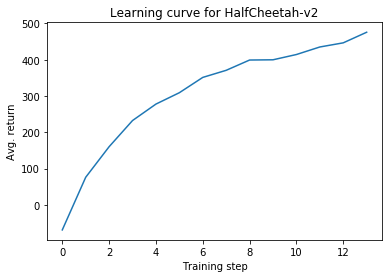

In [16]:
eval_score = [l['avg_return/train'] for l in all_logs]
plt.plot(eval_score)
plt.title(f'Learning curve for {env_name}')
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Visualize trained model's predictions:

Comparing actual obs & rews vs fitted obs & rews given actually happened actions input sequences:

In [17]:
batch = eval_sampler.sample_n_episodes(actor=actor,
                                       n_episodes=20,
                                       max_path_length=200, 
                                       train_sampling=False)

print(*batch.create_logs().items(), sep='\n')

('avg_return', 104.45067196184584)
('std_return', 15.494192694297944)
('max_return', 140.62826902545737)
('min_return', 82.09014699556923)
('mean_pathlen', 200.0)
('n_paths', 20)
('n_transitions', 4000)


In [18]:
# formulate actual obs, starting obs, and actual action sequence
start_index = 50
end_index = 100

assert end_index < min([p.steps for p in batch.rollouts]) # ensure that rollouts are long enough

obs, rews, acs = [], [], []
for p in batch.rollouts:
    obs.append(p.data['obs'][start_index:end_index])
    acs.append(p.data['acs'][start_index:end_index])
    rews.append(p.data['rews'][start_index:end_index])
obs, rews, acs = np.array(obs), np.array(rews), np.array(acs)
obs, rews, acs = np.swapaxes(obs, 0, 1), np.swapaxes(rews, 0, 1), np.swapaxes(acs, 0, 1)

starting_obs = obs[0, :, :]
print(starting_obs.shape, obs.shape, rews.shape, acs.shape)

# Obtain predictions with a model
pred_obs, pred_rews, _ = model.predict_action_sequence(lag_obs=starting_obs,
                                                       action_sequence=acs)
print(pred_obs.shape, pred_rews.shape)

(20, 17) (50, 20, 17) (50, 20) (50, 20, 6)
(50, 20, 17) (50, 20)


In [19]:
# Calculate model's forecast MAE vs naive mean obs forecast MAE
mean_obs = batch.unpack(['obs']).mean(axis=0)[np.newaxis, np.newaxis, :]
mean_rews = batch.unpack(['rews']).mean(axis=0)

act_obs, act_rews = obs, rews

obs_mae = np.abs(act_obs - pred_obs)
mean_obs_mae = np.abs(act_obs - mean_obs)
rews_mae = np.abs(act_rews - pred_rews)
mean_rews_mae = np.abs(act_rews - mean_rews)
obs_mae = np.mean(obs_mae, axis=(1, 2))
mean_obs_mae = np.mean(mean_obs_mae, axis=(1, 2))
rews_mae = np.mean(rews_mae, axis=1)
mean_rews_mae = np.mean(mean_rews_mae, axis=1)

# Obs MAE Model Vs Naive

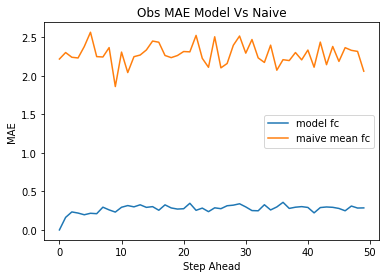

In [20]:
plt.plot(obs_mae, label='model fc')
plt.plot(mean_obs_mae, label='maive mean fc')
plt.ylabel('MAE')
plt.xlabel('Step Ahead')
plt.title('Obs MAE Model Vs Naive')
plt.legend()
plt.show()

# Rews $ R^2 $

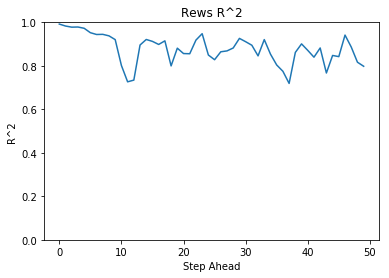

In [22]:
from sklearn.metrics import r2_score

r2 = []
for ar, pr in zip(act_rews, pred_rews):
    r2.append(r2_score(ar, pr))
    
plt.plot(r2)
plt.ylim((0, 1))
plt.ylabel('R^2')
plt.xlabel('Step Ahead')
plt.title('Rews R^2')
plt.show()

# Individual Obs Features Prediction

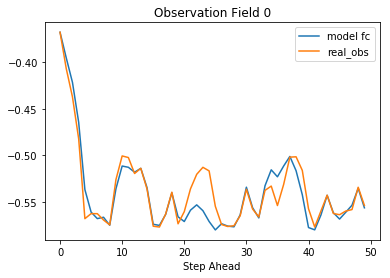

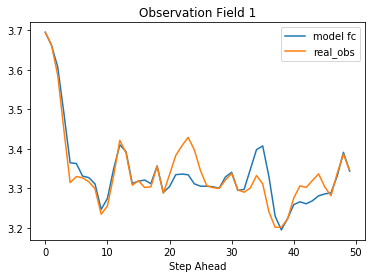

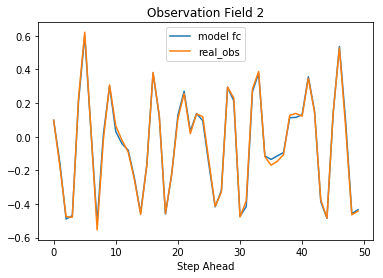

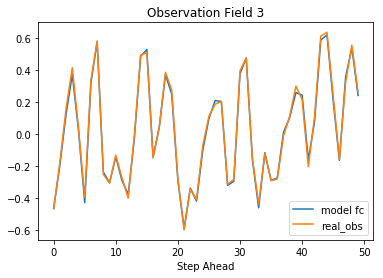

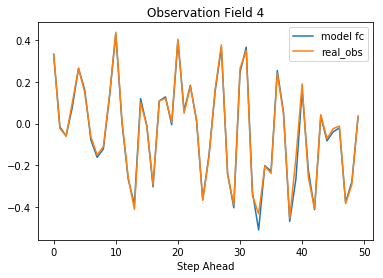

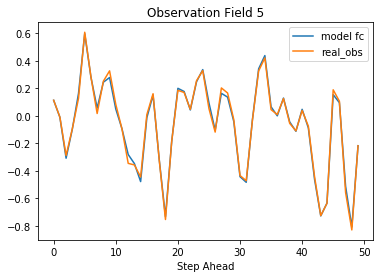

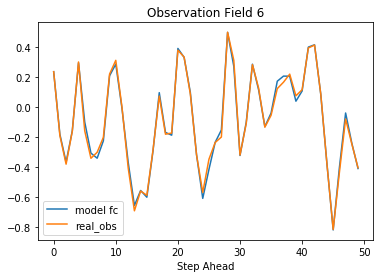

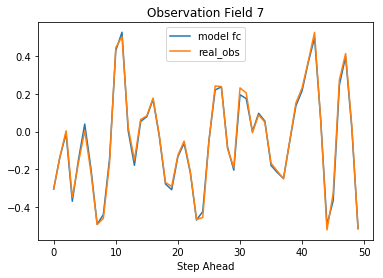

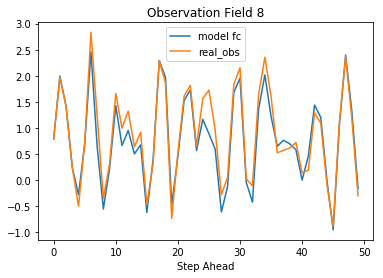

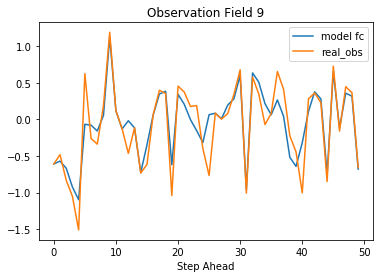

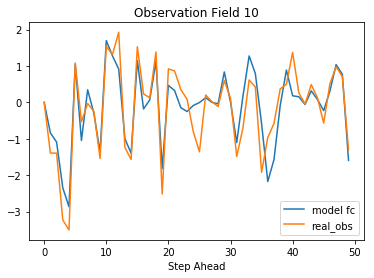

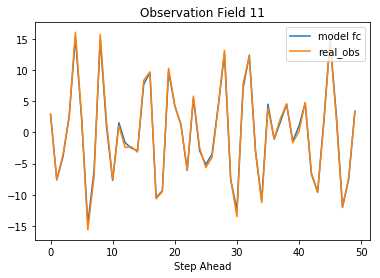

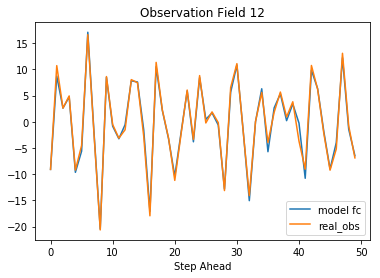

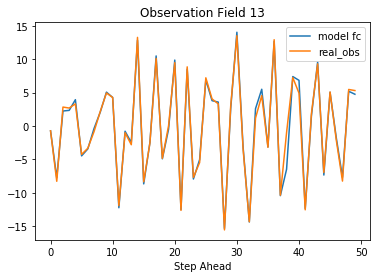

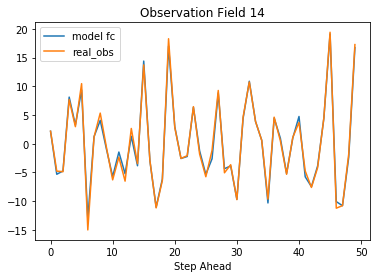

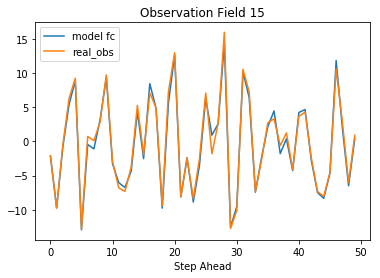

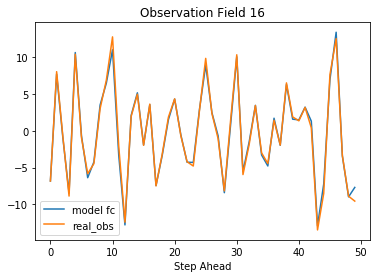

In [23]:
# Plot Each Observation Component forecast:

path_index = 0

for j in range(act_obs.shape[-1]):
    robs = act_obs[:, path_index, j]
    sobs = pred_obs[:, path_index, j]
    plt.plot(sobs, label='model fc')
    plt.plot(robs, label='real_obs')
    plt.title(f'Observation Field {j}')
    plt.xlabel('Step Ahead')
    plt.legend()
    plt.show()

# Fitted Rews Vs Actual Rews

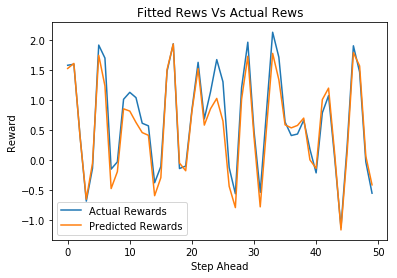

In [24]:
plt.plot(act_rews[:, path_index], label='Actual Rewards')
plt.plot(pred_rews[:, path_index], label='Predicted Rewards')
plt.xlabel('Step Ahead')
plt.ylabel('Reward')
plt.legend()
plt.title('Fitted Rews Vs Actual Rews')
plt.show()

# Visualize trained actor

In [25]:
visualize_actor(env=eval_env, actor=actor, nsteps=200, train_sampling=False)

Simulation done, total reward: 106.00385842839765
Loading video...


# Save Models

In [27]:
actor.save_checkpoint('trained_models', 'random_shooting_actor')
model.save_checkpoint('trained_models', 'delta_env_model')

Saved checkpoints for RandomShooting...
global_step
Saved checkpoints for DeltaEnvModel...
models_state_dict global_step local_step n_updates n_stats_updates n_model_resets updates_per_model obs_optimizer_0 obs_scheduler_0 obs_optimizer_1 obs_scheduler_1 obs_optimizer_2 obs_scheduler_2 obs_optimizer_3 obs_scheduler_3 obs_optimizer_4 obs_scheduler_4 obs_optimizer_5 obs_scheduler_5 obs_optimizer_6 obs_scheduler_6 rews_optimizer_0 rews_scheduler_0 rews_optimizer_1 rews_scheduler_1 rews_optimizer_2 rews_scheduler_2 rews_optimizer_3 rews_scheduler_3 rews_optimizer_4 rews_scheduler_4 rews_optimizer_5 rews_scheduler_5 rews_optimizer_6 rews_scheduler_6 buffer_stats


/home/nikita/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load models

In [ ]:
actor.load_checkpoint('trained_models', 'random_shooting_actor')
model.load_checkpoint('trained_models', 'delta_env_model')